In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
UNPROCESSED_DATASETS_PATH = 'unprocessed_datasets'
PROCESSED_DATASETS_PATH = 'processed_datasets'
SAMPLE_SIZE = len([name for name in os.listdir(UNPROCESSED_DATASETS_PATH) if os.path.isdir(os.path.join(UNPROCESSED_DATASETS_PATH, name))])
EXERCICES_TYPE = set()
SENSORS_TYPE = {}

In [4]:
def transpose_data(input_file):
    # Charger les données depuis le fichier CSV
    data = pd.read_csv(input_file)
    
    # Identifier les clés non numériques
    non_numeric_keys = [key for key in data.columns if not (isinstance(key, (int, float)) or key.isdigit())]
    
    # Vérifier s'il y a des colonnes non numériques
    if non_numeric_keys:
        # Renommer la première colonne non numérique en 'ID'
        data = data.rename(columns={non_numeric_keys[0]: 'ID'})
        
        # Mettre 'ID' en index et transposer les données
        data = data.set_index('ID').transpose()
    else:
        # Si aucune colonne non numérique, ne pas effectuer de renommage ni de transposition
        data = data.transpose()
    
    return data


In [ ]:
# Traverse the dataset path
for root, dirs, files in os.walk(UNPROCESSED_DATASETS_PATH):
    # Process directories (exercise types)
    for dir_name in dirs:
        if not dir_name.isdigit():
            EXERCICES_TYPE.add(dir_name)  # Add to set (automatically avoids duplicates)
    
    # Process files (sensor types)
    for file_name in files:
        print(f"Processing file: {file_name}")
        sensor_type = file_name.split('_')[0]  # Extract the sensor type
        
        # Add sensor type with its corresponding sampling rate if not already present
        if sensor_type not in SENSORS_TYPE:
            match sensor_type:
                case 'emg':
                    SENSORS_TYPE['emg'] = 2000
                case 'imu':
                    SENSORS_TYPE['imu'] = 100
                case 'ips':
                    SENSORS_TYPE['ips'] = 60
                case 'cop':
                    SENSORS_TYPE['cop'] = 60
                case 'mocap':
                    SENSORS_TYPE['mocap'] = 100

# Convert EXERCICES_TYPE back to list if needed
EXERCICES_TYPE = list(EXERCICES_TYPE)

# Output the results
print("\nEXERCICES_TYPE:")
print(EXERCICES_TYPE)

print("\nSENSORS_TYPE:")
print(SENSORS_TYPE)



EXERCICES_TYPE:
['halfsquat', 'still', 'back', 'forward']

SENSORS_TYPE:
{'cop': 60, 'emg': 2000, 'imu': 100, 'ips': 60, 'mocap': 100}


In [4]:
EXERCICES_TYPE = []
SENSORS_TYPE = {}

for root, dirs, files in os.walk(UNPROCESSED_DATASETS_PATH):
    for dir_name in dirs:
        if not dir_name.isdigit() and dir_name not in EXERCICES_TYPE:
            EXERCICES_TYPE.append(dir_name)          

    for file_name in files:
        if file_name.split('_')[0] not in SENSORS_TYPE:
            match file_name.split('_')[0]:
                case 'emg':
                    SENSORS_TYPE['emg'] = 2000
                case 'imu':
                    SENSORS_TYPE['imu'] = 100
                case 'ips':
                    SENSORS_TYPE['ips'] = 60
                case 'cop':
                    SENSORS_TYPE['cop'] = 60
                case 'mocap':
                    SENSORS_TYPE['mocap'] = 100
            
            

print("\nEXERCICES_TYPE :")
print(EXERCICES_TYPE)

print("\nSENSORS_TYPE :")
print(SENSORS_TYPE)


EXERCICES_TYPE :
['back', 'forward', 'halfsquat', 'still']

SENSORS_TYPE :
{'cop': 60, 'emg': 2000, 'imu': 100, 'ips': 60, 'mocap': 100}


In [5]:
def save_to_csv(df, output_dir):
        os.makedirs(os.path.dirname(output_dir), exist_ok=True)
        df.to_csv(output_dir, index=False)

def process_data(input_file):
        data = pd.read_csv(input_file)
        non_numeric_keys = [key for key in data.keys() if not (isinstance(key, (int, float)) or key.isdigit())]
        data = data.rename(columns={non_numeric_keys[0]: 'ID'})
        data = data.set_index('ID').transpose()
        return data

def existing_directory(output_dir):
    if os.path.exists(output_dir):
        print(f"File {output_dir} already exists")
        return True
    return False

In [6]:
def resampling(dataset_wrong_frequency,dataset_desired_frequency,wrong_frequency,desired_frequency):
    if wrong_frequency == desired_frequency:
        return dataset_wrong_frequency
    
    df_wrong_Hz = dataset_wrong_frequency
    sampling_rate_wrong_Hz = wrong_frequency
    df_wrong_Hz['time'] =  pd.date_range(start='00:00:00', periods=df_wrong_Hz.shape[0], freq=f'{int(1e6 / sampling_rate_wrong_Hz)}us')

    n_points_wrong_Hz = len(df_wrong_Hz)
    n_points_desired_Hz = dataset_desired_frequency.shape[0]
    print(n_points_desired_Hz)

    time = pd.date_range(start=df_wrong_Hz['time'].iloc[0],periods=n_points_desired_Hz,freq=f'{int(desired_frequency/10)}ms')
    df_wrong_Hz.set_index('time', inplace=True)
    df_wrong_Hz_resampled = df_wrong_Hz.reindex(time).interpolate(method='linear')
    
    # Affichage des résultats
    print(f"Nombre de points à {wrong_frequency} Hz avant interpolation:", n_points_wrong_Hz)
    print(f"Nombre de points à {desired_frequency}  Hz après interpolation:", len(df_wrong_Hz_resampled))
    return df_wrong_Hz_resampled

In [7]:
def combine_and_harmonize(sensor,sensor_rate,correct_rate):
    df = pd.DataFrame()
    
    for exercice in EXERCICES_TYPE:
        for i in range(1, SAMPLE_SIZE):
            try:
                input_file = f'{UNPROCESSED_DATASETS_PATH}/{i}/{exercice}/{sensor}_1.csv'
                correct_sampling = process_data(f"{UNPROCESSED_DATASETS_PATH}/{i}/{exercice}/cop_1.csv")
                print(f'Reading {input_file}')
                processed_data = resampling(process_data(input_file),correct_sampling,sensor_rate,correct_rate)
                processed_data['label'] = exercice
                df = pd.concat([df, processed_data], axis=0).reset_index(drop=True)
            except Exception as e:
                print(f"Error processing file {input_file}: {e}")
                continue
    return df

In [ ]:
for sensor_type,sensor_frequency in SENSORS_TYPE.items():
    output_dir = f"{PROCESSED_DATASETS_PATH}/unbalanced/{sensor_type}.csv"
    print(f"Saving {sensor_type} to output_dir")
    save_to_csv(combine_and_harmonize(f'{sensor_type}',sensor_frequency,60), output_dir)

Saving cop to output_dir
Reading unprocessed_datasets/1/back/cop_1.csv
Reading unprocessed_datasets/2/back/cop_1.csv
Reading unprocessed_datasets/3/back/cop_1.csv
Reading unprocessed_datasets/4/back/cop_1.csv
Reading unprocessed_datasets/5/back/cop_1.csv
Reading unprocessed_datasets/6/back/cop_1.csv
Reading unprocessed_datasets/7/back/cop_1.csv
Reading unprocessed_datasets/8/back/cop_1.csv
Reading unprocessed_datasets/9/back/cop_1.csv
Reading unprocessed_datasets/10/back/cop_1.csv
Reading unprocessed_datasets/11/back/cop_1.csv
Reading unprocessed_datasets/12/back/cop_1.csv
Reading unprocessed_datasets/13/back/cop_1.csv
Reading unprocessed_datasets/14/back/cop_1.csv
Reading unprocessed_datasets/15/back/cop_1.csv
Reading unprocessed_datasets/16/back/cop_1.csv
Reading unprocessed_datasets/17/back/cop_1.csv
Reading unprocessed_datasets/18/back/cop_1.csv
Reading unprocessed_datasets/19/back/cop_1.csv
Reading unprocessed_datasets/20/back/cop_1.csv
Reading unprocessed_datasets/21/back/cop_1.c

In [8]:
number_of_measures = pd.DataFrame(columns=EXERCICES_TYPE, index=SENSORS_TYPE)
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        data = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/{sensor}.csv")
        number_of_measures.loc[sensor,exercice] = data[data['label'] == exercice].shape[0]

In [9]:
number_of_measures

,back,forward,halfsquat,still
cop,86658,72832,80314,83333
emg,86658,72832,80314,83333
imu,86658,72832,80314,83333
ips,91072,75028,84441,83333
mocap,86658,72832,80314,83333


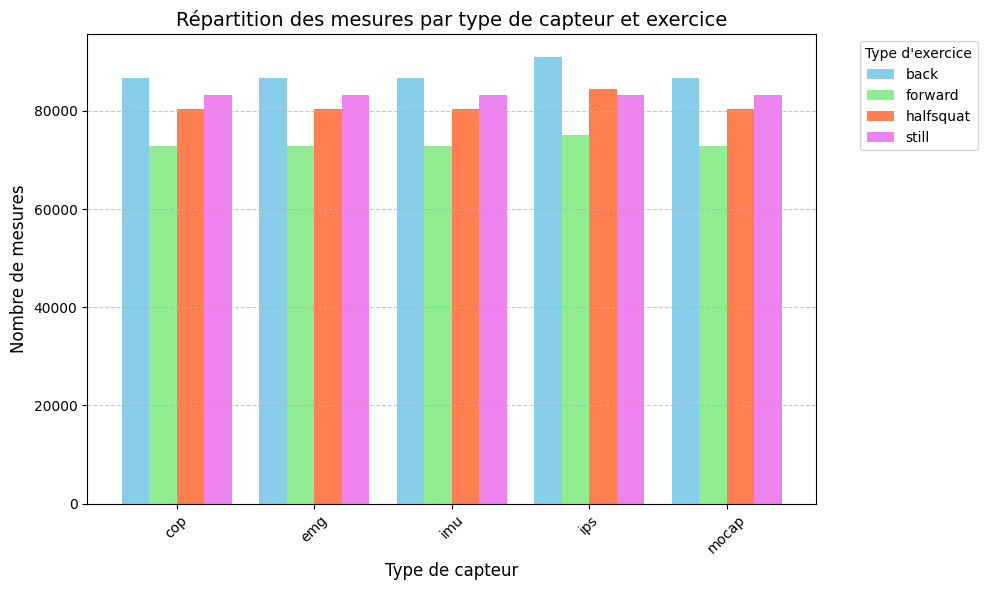

In [10]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped bars
number_of_measures.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet', 'gold'])

# Customize axes
ax.set_xlabel("Type de capteur", fontsize=12)
ax.set_ylabel("Nombre de mesures", fontsize=12)
ax.set_title("Répartition des mesures par type de capteur et exercice", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

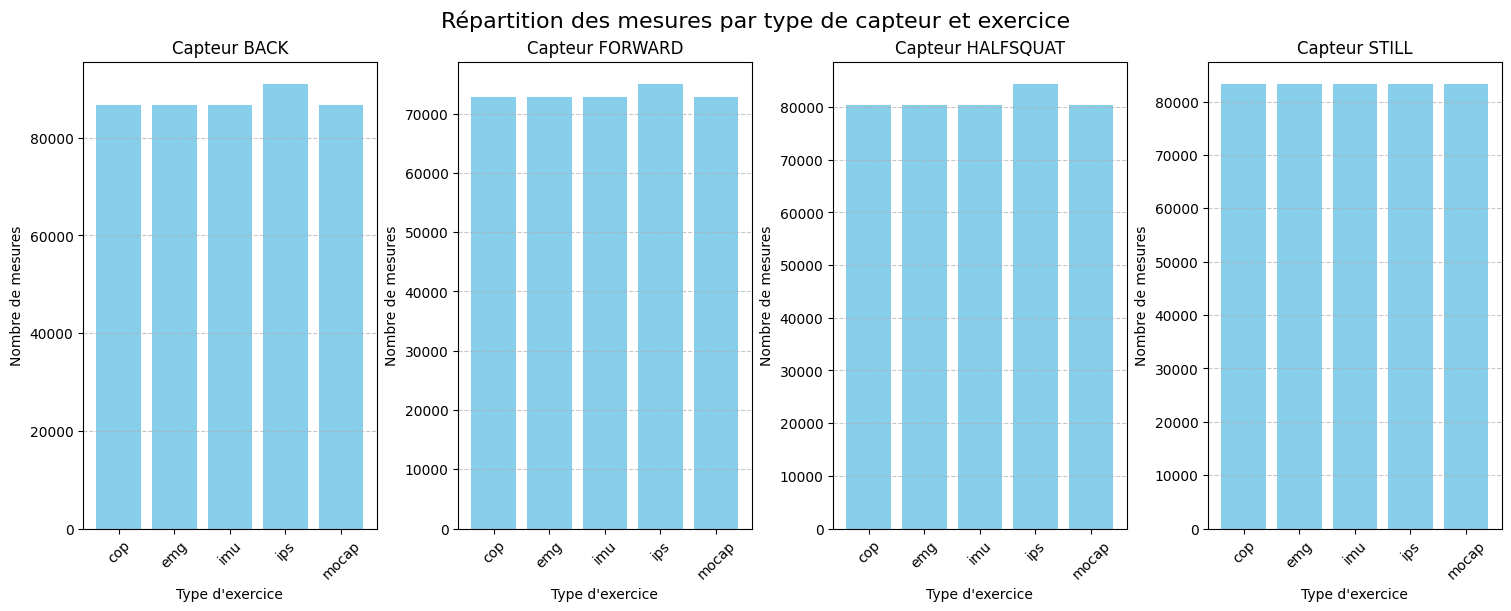

In [11]:
# Nombre de types de capteurs
num_sensors = len(number_of_measures.columns)
fig, axs = plt.subplots(1, num_sensors, figsize=(15, 6), constrained_layout=True)

# Visualisation pour chaque capteur
for i, sensor in enumerate(number_of_measures.columns):
    axs[i].bar(number_of_measures.index, number_of_measures[sensor], color='skyblue')
    axs[i].set_xlabel("Type d'exercice", fontsize=10)
    axs[i].set_ylabel("Nombre de mesures", fontsize=10)
    axs[i].set_title(f"Capteur {sensor.upper()}", fontsize=12)
    axs[i].tick_params(axis='x', rotation=45)  # Rotation des labels de l'axe x pour plus de lisibilité
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille sur l'axe y

# Titre global pour la figure
fig.suptitle("Répartition des mesures par type de capteur et exercice", fontsize=16)
plt.show()

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

for sensor in SENSORS_TYPE:
    combined_df = pd.DataFrame()
    output_dir = f"{PROCESSED_DATASETS_PATH}/balanced/{sensor}.csv"
    if existing_directory(output_dir):
        continue
    print(f"Reading {sensor}.csv")
    df = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/{sensor}.csv")  # Replace with the actual path
    # Combine the datasets
    combined_df = df

    if existing_directory(output_dir) == False:
        combined_df.dropna(inplace=True)
        # Separate features and labels
        X = combined_df.drop(columns=['label'])  # Features
        y = combined_df['label']  # Labels

        # Apply SMOTE to balance the classes
        print(f"Applying SMOTE to {sensor}.csv")
        print(X.shape, y.shape)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        print(f"Applied")
        print(X_resampled.shape, y_resampled.shape)

        # Combine the resampled features and labels into a new DataFrame
        balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
        balanced_df['label'] = y_resampled
        save_to_csv(balanced_df, output_dir)


Reading cop.csv
Applying SMOTE to cop.csv
(314942, 10) (314942,)
Applied
(346632, 10) (346632,)
Reading emg.csv
Applying SMOTE to emg.csv
(323137, 16) (323137,)
Applied
(346632, 16) (346632,)
Reading imu.csv
Applying SMOTE to imu.csv
(323137, 54) (323137,)
Applied
(346632, 54) (346632,)
Reading ips.csv
Applying SMOTE to ips.csv
(333874, 682) (333874,)
Applied
(364288, 682) (364288,)


C:\Users\floda\AppData\Local\Temp\ipykernel_4936\420619681.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_df['label'] = y_resampled


Reading mocap.csv
Applying SMOTE to mocap.csv
(323137, 78) (323137,)
Applied
(346632, 78) (346632,)


In [13]:
number_of_measures = pd.DataFrame(columns=SENSORS_TYPE, index=EXERCICES_TYPE)
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        data = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/balanced/{sensor}.csv")
        number_of_measures.loc[exercice,sensor] = data[data['label'] == exercice].shape[0]

In [14]:
number_of_measures

,cop,emg,imu,ips,mocap
back,86658,86658,86658,91072,86658
forward,86658,86658,86658,91072,86658
halfsquat,86658,86658,86658,91072,86658
still,86658,86658,86658,91072,86658


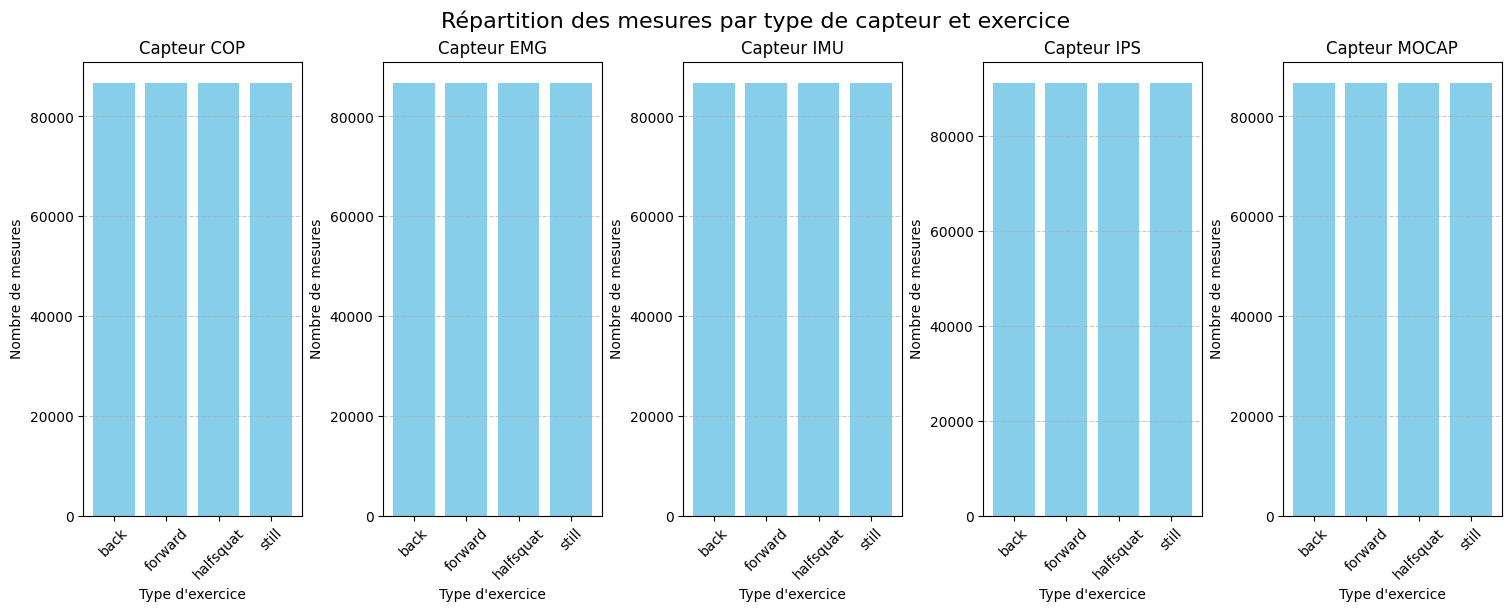

In [15]:
# Nombre de types de capteurs
num_sensors = len(number_of_measures.columns)
fig, axs = plt.subplots(1, num_sensors, figsize=(15, 6), constrained_layout=True)

# Visualisation pour chaque capteur
for i, sensor in enumerate(number_of_measures.columns):
    axs[i].bar(number_of_measures.index, number_of_measures[sensor], color='skyblue')
    axs[i].set_xlabel("Type d'exercice", fontsize=10)
    axs[i].set_ylabel("Nombre de mesures", fontsize=10)
    axs[i].set_title(f"Capteur {sensor.upper()}", fontsize=12)
    axs[i].tick_params(axis='x', rotation=45)  # Rotation des labels de l'axe x pour plus de lisibilité
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille sur l'axe y

# Titre global pour la figure
fig.suptitle("Répartition des mesures par type de capteur et exercice", fontsize=16)
plt.show()

In [43]:
combined_df = pd.DataFrame()
for sensor in SENSORS_TYPE:
    data = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/balanced/{sensor}.csv")
    combined_df.drop(columns=['label'], inplace=True,errors='ignore')
    combined_df = pd.concat([combined_df, data], axis=1)

In [47]:
combined_df.dropna(inplace=True)

In [93]:
import numpy as np
import pandas as pd

# Fonction pour créer des fenêtres de taille fixe (1 seconde ici)
def create_windows(data, window_size, step_size):
    """
    Crée des fenêtres glissantes à partir des données.
    :param data: array-like, données à segmenter
    :param window_size: int, taille de la fenêtre (en nombre d'échantillons)
    :param step_size: int, pas de la fenêtre (en nombre d'échantillons)
    :return: X (données segmentées), y (étiquettes correspondantes)
    """
    windows = []
    labels = []

    # Découper les données en fenêtres glissantes
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        window = data[start:end].drop('label', axis=1)  # Exclure la colonne 'label'
        windows.append(window[:-1])

        # L'étiquette correspond à la classe à partir du centre de la fenêtre
        # Cela suppose que l'étiquette correspond à la fenêtre entière
        labels.append(data.iloc[end - 1]['label'])  # Utiliser l'étiquette à la fin de la fenêtre
    
    # Convertir en arrays numpy pour Keras
    X = np.array(windows)  # Exclure la dernière fenêtre pour éviter les problèmes de dimensions
    y = np.array(labels)

    

    return X, y

# Exemple : chargement des données brutes

# Paramètres de la fenêtre
window_size = 60  # Taille de la fenêtre (60 échantillons pour 1 seconde)
step_size = 60  # Pas de la fenêtre (60 échantillons pour pas de chevauchement)

# Segmenter les données en fenêtres
X, y = create_windows(data, window_size, step_size)

# Affichage des dimensions des données segmentées
print(f'X shape: {X.shape}, y shape: {y.shape}')


X shape: (5777, 59, 840), y shape: (5777,)


In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Normalisation des données sur chaque fenêtre
scaler = StandardScaler()

# Appliquer la normalisation sur chaque fenêtre (chaque "fenêtre" dans X)
X_scaled = np.array([scaler.fit_transform(window) for window in X])

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Encodage des labels en one-hot
y_encoded = to_categorical(label_encoder.fit_transform(y), num_classes=4)

# Diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')


test
test1
test2
X_train shape: (4621, 59, 840), X_test shape: (1156, 59, 840)


In [123]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Définir un modèle CNN-LSTM
def create_cnn_lstm_model(input_shape):
    model = Sequential()

    # Ajouter une couche CNN
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # Ajouter une couche LSTM
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))

    # Couche dense de sortie
    model.add(Dense(4, activation='softmax'))  # 4 classes à prédire

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Créer le modèle CNN-LSTM
cnn_lstm_model = create_cnn_lstm_model(X_train.shape[1:3])

# Entraîner le modèle
history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm}")


Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3953 - loss: 1.2954 - val_accuracy: 0.6012 - val_loss: 0.9677
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6373 - loss: 0.8942 - val_accuracy: 0.6877 - val_loss: 0.7645
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7599 - loss: 0.6156 - val_accuracy: 0.7846 - val_loss: 0.6127
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8472 - loss: 0.4285 - val_accuracy: 0.8054 - val_loss: 0.6018
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8916 - loss: 0.2921 - val_accuracy: 0.8452 - val_loss: 0.5056
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9204 - loss: 0.2186 - val_accuracy: 0.8529 - val_loss: 0.4557
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9413 - loss: 0.1698 - val_accuracy: 0.9040 - val_loss: 0.3753
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9517 - loss: 0.1386 - val_accuracy: 0

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Rapport de Classification :
               precision    recall  f1-score   support

        back       0.93      0.91      0.92       312
     forward       0.92      0.96      0.94       278
   halfsquat       0.93      0.80      0.86       299
       still       0.81      0.92      0.86       267

    accuracy                           0.90      1156
   macro avg       0.90      0.90      0.89      1156
weighted avg       0.90      0.90      0.90      1156



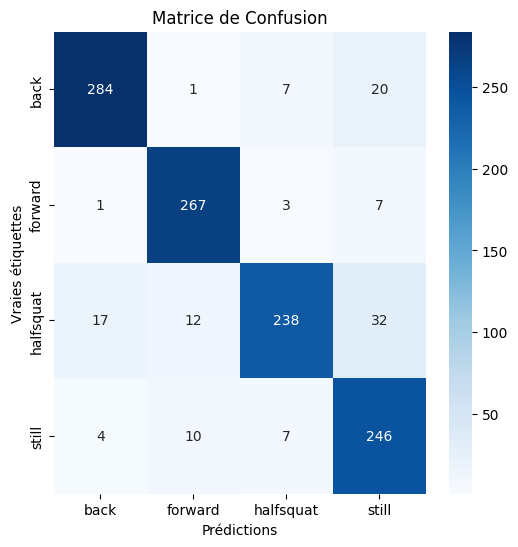

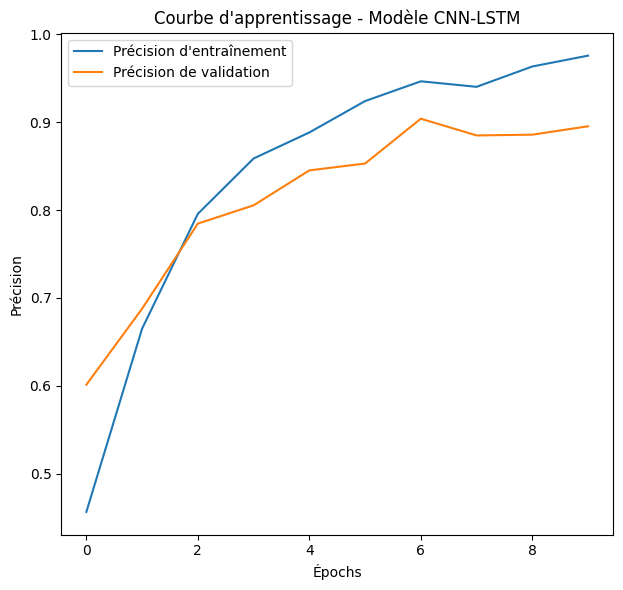

In [131]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Prédictions sur l'ensemble de test
# Convertir les prédictions en labels d'indices entiers
y_pred = np.argmax(cnn_lstm_model.predict(X_test), axis=-1)

# Si y_test est one-hot encodé, convertir y_test en labels d'indices entiers
y_test_labels = np.argmax(y_test, axis=-1)

# Générer un rapport de classification
report = classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_)
print("Rapport de Classification :\n", report)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

# Courbes d'apprentissage pour les deux modèles
plt.figure(figsize=(12, 6))

# Modèle CNN-LSTM
plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Modèle CNN-LSTM')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()


In [165]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Architecture CNN-LSTM multimodale
def create_cnn_lstm_multimodal_model(input_shapes):
    # Sous-modèle EMG (ici on suppose que c'est une séquence temporelle, donc on utilise un CNN-LSTM)
    emg_input = Input(shape=input_shapes[0], name='emg_input')
    x = Conv1D(32, kernel_size=3, activation='relu')(emg_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64, activation='relu', return_sequences=False)(x)
    emg_dense = Dropout(0.2)(x)
    
    # Sous-modèle IMU (si c'est aussi une séquence temporelle, appliquer CNN-LSTM ici aussi)
    imu_input = Input(shape=input_shapes[1], name='imu_input')
    y = Conv1D(32, kernel_size=3, activation='relu')(imu_input)
    y = MaxPooling1D(pool_size=2)(y)
    y = Dropout(0.2)(y)
    y = LSTM(64, activation='relu', return_sequences=False)(y)
    imu_dense = Dropout(0.2)(y)

    # Sous-modèle IPS (données non séquentielles, on utilise des couches denses simples)
    ips_input = Input(shape=input_shapes[2], name='ips_input')
    z= Conv1D(32, kernel_size=3, activation='relu')(ips_input)
    z = MaxPooling1D(pool_size=2)(z)
    z = Dropout(0.2)(z)
    z = LSTM(64, activation='relu', return_sequences=False)(z)
    ips_dense = Dropout(0.2)(z)

    # Fusion des sorties (EMG, IMU, IPS)
    concatenated = Concatenate()([emg_dense, imu_dense,ips_dense])

    # Couche dense après fusion
    dense = Dense(64, activation='relu')(concatenated)
    dense = Dropout(0.2)(dense)

    # Couche de sortie
    output = Dense(4, activation='softmax')(dense)  # 4 classes à prédire

    # Création du modèle final
    model = Model(inputs=[emg_input, imu_input, ips_input], outputs=output)

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [147]:
from sklearn.preprocessing import StandardScaler

X_ips, y = create_windows(pd.read_csv(f"{PROCESSED_DATASETS_PATH}/balanced/ips.csv"), window_size, step_size)
X_emg, y = create_windows(pd.read_csv(f"{PROCESSED_DATASETS_PATH}/balanced/emg.csv"), window_size, step_size)
X_imu, y = create_windows(pd.read_csv(f"{PROCESSED_DATASETS_PATH}/balanced/imu.csv"), window_size, step_size)

# Normalisation pour chaque modalité (EMG, IMU, IPS)
scaler = StandardScaler()

# Normaliser les données EMG et IMU sur chaque fenêtre (chaque "fenêtre" dans X_emg et X_imu)
X_emg_scaled = np.array([scaler.fit_transform(window) for window in X_emg])
X_imu_scaled = np.array([scaler.fit_transform(window) for window in X_imu])
X_ips_scaled = np.array([scaler.fit_transform(window) for window in X_ips])
X_ips_scaled = X_ips_scaled[0:5777]


In [148]:
X_emg_scaled.shape, X_imu_scaled.shape, X_ips_scaled.shape

((5777, 59, 16), (5777, 59, 54), (5777, 59, 682))

In [149]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encodage des labels en one-hot
label_encoder = LabelEncoder()
y_encoded = to_categorical(label_encoder.fit_transform(y), num_classes=4)


In [150]:
y_encoded.shape

(5777, 4)

In [ ]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test (80% - 20%)
X_emg_train, X_emg_test, X_imu_train, X_imu_test, X_ips_train, X_ips_test, y_train, y_test = train_test_split(
    X_emg_scaled, X_imu_scaled, X_ips_scaled, y_encoded, test_size=0.2, random_state=42
)

print(f'X_emg_train shape: {X_emg_train.shape}, X_imu_train shape: {X_imu_train.shape}, X_ips_train shape: {X_ips_train.shape}')
print(f'X_emg_test shape: {X_emg_test.shape}, X_imu_test shape: {X_imu_test.shape}, X_ips_test shape: {X_ips_test.shape}')


X_emg_train shape: (4621, 59, 16), X_imu_train shape: (4621, 59, 54), X_ips_train shape: (4621, 59, 682)
X_emg_test shape: (1156, 59, 16), X_imu_test shape: (1156, 59, 54), X_ips_test shape: (1156, 59, 682)


In [166]:
input_shapes = [
    X_emg_train.shape[1:3],
    X_imu_train.shape[1:3],
    X_ips_train.shape[1:3],
]

print(input_shapes)

cnn_lstm_multimodal_model = create_cnn_lstm_multimodal_model(input_shapes)

[(59, 16), (59, 54), (59, 682)]


In [167]:
# Entraînement du modèle multimodal CNN-LSTM
cnn_lstm_multimodal_model.fit(
    [X_emg_train, X_imu_train, X_ips_train], y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_emg_test, X_imu_test, X_ips_test], y_test)
)


Epoch 1/10


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['emg_input', 'imu_input', 'ips_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3734 - loss: 1.3075 - val_accuracy: 0.6375 - val_loss: 0.9774
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6312 - loss: 0.9237 - val_accuracy: 0.6843 - val_loss: 1.0380
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7292 - loss: 0.7053 - val_accuracy: 0.7742 - val_loss: 0.6704
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8114 - loss: 0.5024 - val_accuracy: 0.8131 - val_loss: 0.6074
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8387 - loss: 0.4257 - val_accuracy: 0.8417 - val_loss: 0.4886
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8717 - loss: 0.3585 - val_accuracy: 0.8313 - val_loss: 0.5323
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9088 - loss: 0.2578 - val_accuracy: 0.8772 - val_loss: 0.4263
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9402 - loss: 0.1823 - val_accuracy: 0.8841 - val

In [168]:
# Afficher le résumé du modèle
cnn_lstm_multimodal_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emg_input           │ (None, 59, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imu_input           │ (None, 59, 54)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ips_input           │ (None, 59, 682)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 57, 32)    │      1,568 │ emg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 57, 32)    │      5,216 │ imu_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 57, 32)    │     65,504 │ ips_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 28, 32)    │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 28, 32)    │          0 │ conv1d_22[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 28, 32)    │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 28, 32)    │          0 │ max_pooling1d_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 28, 32)    │          0 │ max_pooling1d_12… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 28, 32)    │          0 │ max_pooling1d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     24,832 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 64)        │     24,832 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 64)        │     24,832 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64)        │          0 │ lstm_10[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 64)        │          0 │ lstm_11[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 192)       │          0 │ dropout_28[0][0]

 Total params: 478,190 (1.82 MB)

 Trainable params: 159,396 (622.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 318,794 (1.22 MB)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Rapport de Classification :
               precision    recall  f1-score   support

        back       0.82      0.96      0.89       312
     forward       0.94      0.96      0.95       278
   halfsquat       0.95      0.69      0.80       299
       still       0.81      0.89      0.84       267

    accuracy                           0.87      1156
   macro avg       0.88      0.87      0.87      1156
weighted avg       0.88      0.87      0.87      1156



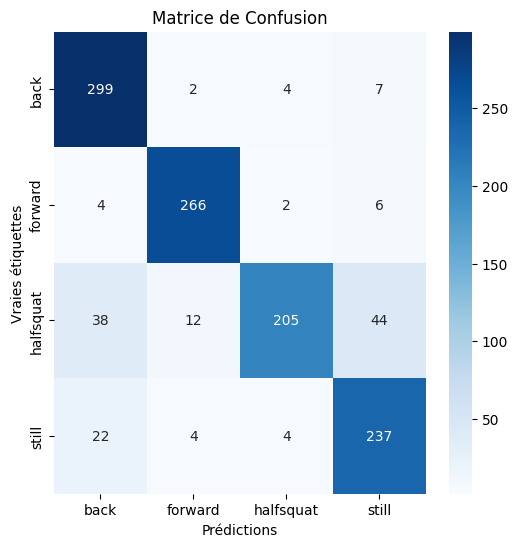

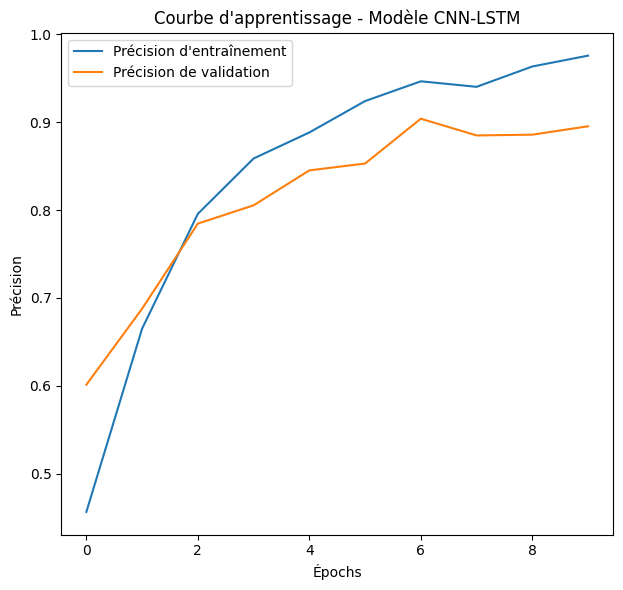

In [170]:
# Prédictions sur l'ensemble de test
# Convertir les prédictions en labels d'indices entiers
predictions = cnn_lstm_multimodal_model.predict([X_emg_test,X_imu_test,X_ips_test])


y_pred = np.argmax(predictions, axis=-1)

# Si y_test est one-hot encodé, convertir y_test en labels d'indices entiers
y_test_labels = np.argmax(y_test, axis=-1)

# Générer un rapport de classification
report = classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_)
print("Rapport de Classification :\n", report)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

# Courbes d'apprentissage pour les deux modèles
plt.figure(figsize=(12, 6))

# Modèle CNN-LSTM
plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Modèle CNN-LSTM')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

# Charger les données normalisées
data = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/ips.csv")

# Séparer les labels
labels = data['label']
data = data.drop(columns=['label'])

# Appliquer l'ACP
pca = PCA(n_components=0.95)  # Conserver 95% de la variance
reduced_data = pca.fit_transform(data)

# Créer un DataFrame avec les composantes principales
reduced_df = pd.DataFrame(reduced_data, columns=[f"PC{i+1}" for i in range(reduced_data.shape[1])])
reduced_df['label'] = labels

# Sauvegarder les données réduites
reduced_df.to_csv("pca_reduced_data.csv", index=False)

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))  # Doit être proche de 0.95

